# notes
- ~~use last char in sequence as focal token~~
- ~~introduce CLS token at beginning of sequence~~
- ~~back to last non-embedding char~~
- masked character modeling > causal masking: learns latent structure behind names by predicting random characters (feature extraction): validation by regression stage
  - drop causal masking
  - reduce dropout
  - mean token embedding > eow token embedding

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader
from matplotlib import pyplot
import random

from matplotlib import pyplot as plt

from google.colab import drive
drive.mount('/content/drive')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Mounted at /content/drive
Using device: cuda


In [ ]:
torch.manual_seed(7)
np.random.seed(7)
random.seed(7)

In [ ]:
dff = pd.read_csv("/content/drive/MyDrive/vorname/df_female.csv")
dfm = pd.read_csv("/content/drive/MyDrive/vorname/df_male.csv")
df_raw = pd.concat([dff, dfm], axis = 0)
print(dff.shape)
print(dfm.shape)
print(df_raw.shape)

(517286, 4)
(458782, 4)
(976068, 4)


In [ ]:
# pretraining on unique names only
df = df_raw[["name"]].drop_duplicates().copy().reset_index(drop=True)
print(df.shape)

(65401, 1)


In [ ]:
# simplify
df["drop"] = 0
df.loc[df["name"].str.contains("'"), "drop"] = 1
df = df.loc[df["drop"] == 0, :]

print(df.shape)

df["name_lower"] = df["name"].str.lower()



(65373, 2)


<ipython-input-5-a485e5639b44>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["name_lower"] = df["name"].str.lower()


In [ ]:
# add end-of-sequence token
df["namedot"] = df["name_lower"].astype(str) + "."

In [ ]:
print(df["namedot"].str.len().value_counts().sort_index())
max_length = df["namedot"].str.len().max()
max_length

namedot
3       128
4      1094
5      5780
6     13787
7     16067
8     12108
9      7288
10     3717
11     2013
12     1155
13      811
14      559
15      384
16      233
17      131
18       75
19       30
20        9
21        4
Name: count, dtype: int64


21

In [ ]:
# build vocab

all_text = ''.join(df["namedot"])
vocab = sorted(set(all_text))

char_to_idx = {ch: idx for idx, ch in enumerate(vocab)}
idx_to_char = {idx: ch for ch, idx in char_to_idx.items()}

# Add "<pad>" token as padding
pad_token = "<pad>"
char_to_idx[pad_token] = len(char_to_idx)
idx_to_char[len(idx_to_char)] = pad_token

# Add "<mask>" token
mask_token = "<mask>"
char_to_idx[mask_token] = len(char_to_idx)
idx_to_char[len(idx_to_char)] = mask_token

vocab_size = len(char_to_idx)
pad_idx = char_to_idx["<pad>"]
mask_idx = char_to_idx["<mask>"]

print(len(char_to_idx), len(idx_to_char))
print(char_to_idx)

59 59
{'-': 0, '.': 1, 'a': 2, 'b': 3, 'c': 4, 'd': 5, 'e': 6, 'f': 7, 'g': 8, 'h': 9, 'i': 10, 'j': 11, 'k': 12, 'l': 13, 'm': 14, 'n': 15, 'o': 16, 'p': 17, 'q': 18, 'r': 19, 's': 20, 't': 21, 'u': 22, 'v': 23, 'w': 24, 'x': 25, 'y': 26, 'z': 27, 'à': 28, 'á': 29, 'â': 30, 'ã': 31, 'ä': 32, 'å': 33, 'ç': 34, 'è': 35, 'é': 36, 'ê': 37, 'ë': 38, 'ì': 39, 'í': 40, 'î': 41, 'ï': 42, 'ð': 43, 'ñ': 44, 'ò': 45, 'ó': 46, 'ô': 47, 'õ': 48, 'ö': 49, 'ø': 50, 'ù': 51, 'ú': 52, 'û': 53, 'ü': 54, 'ý': 55, 'ÿ': 56, '<pad>': 57, '<mask>': 58}


In [ ]:
# train val split
df["train_val"] = 0
df.loc[df.sample(frac=0.2).index, "train_val"] = 1
print(df["train_val"].value_counts())

train_names = df[df["train_val"] == 0]["namedot"].unique()
val_names = df[df["train_val"] == 1]["namedot"].unique()


train_val
0    52298
1    13075
Name: count, dtype: int64


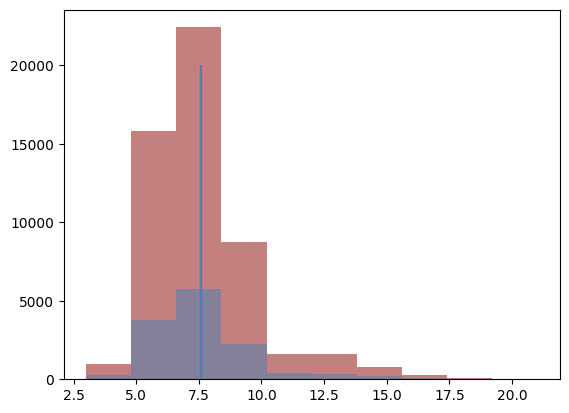

In [ ]:
len_train_names = [len(name) for name in train_names]
len_val_names = [len(name) for name in val_names]
pyplot.hist(len_train_names, color = "darkred", alpha = .5)
pyplot.hist(len_val_names, color = "steelblue", alpha = .5)
pyplot.vlines(np.mean(len_train_names), ymin=0, ymax=20000, color = "red")
pyplot.vlines(np.mean(len_val_names), ymin=0, ymax=20000, color = "steelblue")
pyplot.show()

In [ ]:
# Dataset
class NameDataset(Dataset):
    def __init__(self, names):
        self.data = [[char_to_idx[c] for c in name.lower()] for name in names]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        tokens = torch.tensor(self.data[idx], dtype=torch.long)
        return tokens

# executed anew in each epoch --> different masking pattern on same strings over diff epochs
def collate_fn(batch, mask_prob=0.2):
    batch = pad_sequence(batch, batch_first=True, padding_value=pad_idx)
    inputs = batch.clone()
    labels = batch.clone()

    for i in range(inputs.size(0)):  # For each sequence in batch
        valid_indices = (inputs[i] != pad_idx).nonzero(as_tuple=True)[0]
        num_to_mask = max(1, int(len(valid_indices) * mask_prob))
        mask_indices = random.sample(valid_indices.tolist(), num_to_mask)
        inputs[i, mask_indices] = mask_idx
        labels[i, [j for j in range(inputs.size(1)) if j not in mask_indices]] = -100
        labels[labels == pad_idx] = -100

    return inputs, labels



In [ ]:
## demo
#
#embed_dim=128
#num_heads=4
#hidden_dim=256
#num_layers=2
#dropout=0.1
#
#demo_embedding = nn.Embedding(vocab_size, embed_dim)
#demo_encoder_layer = nn.TransformerEncoderLayer(
#            d_model=embed_dim,
#            nhead=num_heads,
#            dim_feedforward=hidden_dim,
#            dropout=dropout,
#            batch_first=True  # important
#        )
#demo_encoder = nn.TransformerEncoder(demo_encoder_layer, num_layers=num_layers)
#demo_head = nn.Linear(embed_dim, vocab_size)
#
#
#dataset = NameDataset(train_names)
#dataloader = DataLoader(dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
#
#for x,y in dataloader:
#  print(x.shape), print(y.shape)
#  #print(x), print(y)
#  mask = (x == pad_idx)  # shape: (batch_size, seq_len)
#  x = demo_embedding(x)  # (batch_size, seq_len, embed_dim)
#  # Causal mask for attention (shape: (seq_len, seq_len))
#  seq_len = x.size(1)
#  #causal_mask = torch.triu(torch.ones(seq_len, seq_len, device=x.device) == 1, diagonal=1).bool()  # seq_len * se_len
#  #causal_mask = causal_mask.float().masked_fill(causal_mask, float('-inf'))                 # seq_len * se_len
#  causal_mask = torch.triu(torch.ones(seq_len, seq_len, device=x.device), diagonal=1).bool()
#  # Transformer expects (batch_size, seq_len, embed_dim) with batch_first=True
#  #print(x.shape)                                                                            # batch size * seq_len * embed_dim
#  x = demo_encoder(x, mask=causal_mask, src_key_padding_mask=mask)                          # batch size * seq_len * embed_dim
#  logits = demo_head(x)                                                                        # batch size * seq_len * vocab_size
#  print(logits.shape)
#  print(logits.reshape(-1, vocab_size).shape)
#  print(y.reshape(-1).shape)
#  #loss = criterion(logits.reshape(-1, vocab_size), y.reshape(-1))
#
#  break



In [ ]:
class TransformerMaskedModel(nn.Module):
    def __init__(self, vocab_size, embed_dim=128, num_heads=4, hidden_dim=128, num_layers=4, dropout=0.1, max_len=21):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_idx)
        self.pos_embedding = nn.Parameter(torch.randn(1, max_len, embed_dim))  # learnable pos embeddings
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=num_heads,
            dim_feedforward=hidden_dim,
            dropout=dropout,
            batch_first=True  # important
        )
        self.layer_norm = nn.LayerNorm(embed_dim)
        self.dropout = nn.Dropout(p=dropout)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.head = nn.Linear(embed_dim, vocab_size)

    def forward(self, x):
        # x: (batch_size, seq_len)
        mask = (x == pad_idx)  # shape: (batch_size, seq_len)
        # Causal mask for attention (shape: (seq_len, seq_len))
        seq_len = x.size(1)
        x = self.embedding(x) + self.pos_embedding[:, :seq_len] # ? (batch_size, seq_len, embed_dim)
        x = self.layer_norm(x)
        x = self.dropout(x)

        # Transformer expects (batch_size, seq_len, embed_dim) with batch_first=True
        x = self.encoder(x, src_key_padding_mask=mask) # ignore padded positions during attention computation.
        return self.head(x)

    def get_embedding(self, x):
        mask = (x == pad_idx)
        seq_len = x.size(1)
        x = self.embedding(x) + self.pos_embedding[:, :seq_len]
        x = self.layer_norm(x)
        x = self.dropout(x)
        x = self.encoder(x, src_key_padding_mask=mask)
        return x  # shape: (batch_size, seq_len, embed_dim)


In [ ]:
train_dataset = NameDataset(train_names)
val_dataset = NameDataset(val_names)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)


In [ ]:
for x,y in train_loader:
  print(x.shape), print(y.shape)
  print(x), print(y)
  #print([char for char in seq for seq in x])
  break

torch.Size([32, 11])
torch.Size([32, 11])
tensor([[11, 10, 58, 14,  6, 26,  1, 57, 57, 57, 57],
        [ 4, 58, 20, 14, 16,  1, 57, 57, 57, 57, 57],
        [26,  2, 20, 58,  6, 13,  1, 57, 57, 57, 57],
        [10, 19,  7,  6, 21, 58,  1, 57, 57, 57, 57],
        [58,  6, 19, 14,  2, 15,  1, 57, 57, 57, 57],
        [58, 16, 22,  3,  2,  1, 57, 57, 57, 57, 57],
        [12, 19, 16, 15, 58, 57, 57, 57, 57, 57, 57],
        [58,  2, 19, 26, 16, 15,  1, 57, 57, 57, 57],
        [15,  6,  5, 27, 10, 58,  2,  1, 57, 57, 57],
        [11,  2, 12, 16, 58, 57, 57, 57, 57, 57, 57],
        [58, 15, 15,  6,  3, 32, 19,  3, 58, 13,  1],
        [16, 58,  8,  6, 15,  1, 57, 57, 57, 57, 57],
        [58, 58,  6, 19,  0, 13, 22,  4,  2,  1, 57],
        [13,  2, 22, 19, 10,  4, 58,  1, 57, 57, 57],
        [14,  2,  6, 24,  6, 15, 58,  1, 57, 57, 57],
        [58, 16,  6, 13, 10,  1, 57, 57, 57, 57, 57],
        [26, 58, 14,  2, 15,  1, 57, 57, 57, 57, 57],
        [58, 14,  2, 19,  1, 57, 57, 57,

In [ ]:
lr = 1e-4
model = TransformerMaskedModel(vocab_size=vocab_size).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss(ignore_index=-100) # loss is not computed for padded positions.

best_loss = float('inf')
best_model_state = None

for epoch in range(75):
    model.train()
    total_train_loss = 0
    #num_batches = 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        loss = criterion(logits.reshape(-1, vocab_size), y.reshape(-1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        #num_batches += 1


    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            loss = criterion(logits.reshape(-1, vocab_size), y.reshape(-1))
            total_val_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)
    avg_val_loss = total_val_loss / len(val_loader)

    print(f"Epoch {epoch + 1} \t | Avg train Loss: {avg_train_loss:.4f} \t | Avg val Loss: {avg_val_loss:.4f}")
    if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            best_model_state = model.state_dict()
            print("Saving best model")


Epoch 1 	 | Avg train Loss: 2.4433 	 | Avg val Loss: 2.1889
Saving best model
Epoch 2 	 | Avg train Loss: 2.1599 	 | Avg val Loss: 2.0587
Saving best model
Epoch 3 	 | Avg train Loss: 2.0799 	 | Avg val Loss: 1.9891
Saving best model
Epoch 4 	 | Avg train Loss: 2.0334 	 | Avg val Loss: 1.9702
Saving best model
Epoch 5 	 | Avg train Loss: 1.9978 	 | Avg val Loss: 1.9255
Saving best model
Epoch 6 	 | Avg train Loss: 1.9622 	 | Avg val Loss: 1.9119
Saving best model
Epoch 7 	 | Avg train Loss: 1.9445 	 | Avg val Loss: 1.9066
Saving best model
Epoch 8 	 | Avg train Loss: 1.9231 	 | Avg val Loss: 1.8944
Saving best model
Epoch 9 	 | Avg train Loss: 1.9172 	 | Avg val Loss: 1.8629
Saving best model
Epoch 10 	 | Avg train Loss: 1.8940 	 | Avg val Loss: 1.8485
Saving best model
Epoch 11 	 | Avg train Loss: 1.8835 	 | Avg val Loss: 1.8169
Saving best model
Epoch 12 	 | Avg train Loss: 1.8700 	 | Avg val Loss: 1.8139
Saving best model
Epoch 13 	 | Avg train Loss: 1.8534 	 | Avg val Loss: 1.8098


 best val loss: ~~2.18~~
 - ~~2.0936~~
 - ~~1.66~~ (after removing causal masking, allowing for bidirectional attention)
 - 1.54 (after reducing dropout to .1)

In [ ]:
#best_model_state = model.state_dict()
#torch.save(best_model_state, '/content/drive/MyDrive/vorname/best_bert_model.pth')


In [ ]:
# check embeddings


In [ ]:
# check predictions (on a test set)

# Finetuning
regression model for year

In [ ]:
pretrained_bert = TransformerMaskedModel(len(char_to_idx))
pretrained_bert.load_state_dict(torch.load("/content/drive/MyDrive/vorname/best_bert_model.pth", map_location=device), strict = True)

# freeze
for param in pretrained_bert.parameters():
    param.requires_grad = False


In [ ]:
pretrained_bert.to(device)

TransformerMaskedModel(
  (embedding): Embedding(59, 128, padding_idx=57)
  (layer_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-3): 4 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=128, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=128, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (head): Linear(in_features=128, out_features=59, bias=True)
)

In [ ]:

class YearDataset(Dataset):
    def __init__(self, names, years, freqs, char_to_idx):
        self.inputs = []
        self.targets = torch.tensor(years, dtype=torch.float32)
        self.freqs = torch.tensor(freqs, dtype=torch.float32)
        for name in names:
            idxs = [char_to_idx[c] for c in name.lower() + "."]
            self.inputs.append(torch.tensor(idxs, dtype=torch.long))

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        return self.inputs[idx], self.targets[idx], self.freqs[idx]

def collate_fn_year(batch):
    inputs, targets, freqs = zip(*batch)
    inputs_padded = pad_sequence(inputs, batch_first=True, padding_value=pad_idx)
    targets = torch.stack(targets)
    freqs = torch.stack(freqs)
    return inputs_padded, targets, freqs



df_years = df_raw[["name", "year","freq"]].dropna()
#df_years["drop"] = 0
#df_years.loc[df_years["name"].str.contains("'"), "drop"] = 1
#df_years = df_years.loc[df_years["drop"] == 0, :]
df_years = df_years.loc[~df_years["name"].str.contains("'")]


## explode df to take frequency into account
df_years_exp = df_years.loc[df_years.index.repeat(df_years['freq'])].reset_index(drop=True)
df_years_exp.drop(columns="freq", inplace=True)

# standardize dv
year_mean = df_years["year"].mean()
year_std = df_years["year"].std()
df_years["z_year"] = (df_years["year"] - year_mean) / year_std

## sample obs
#n = int(1e6) # 3_000_000
#df_years = df_years.sample(n, random_state=7)

# train val split
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(df_years, test_size=0.2, random_state=42, shuffle=True)

train_dataset = YearDataset(train_df["name"].values, train_df["year"].values, train_df["freq"].values, char_to_idx)
val_dataset = YearDataset(val_df["name"].values, val_df["year"].values, val_df["freq"].values, char_to_idx)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn_year)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn_year)    # shuffle=False for validation



In [ ]:
len(train_loader) * 32

780704

In [ ]:
len(val_loader) * 32

195200

In [ ]:
# benchmarks
names_mean = df_years_exp.groupby("name")["year"].mean().reset_index(drop=False)
names_mean.rename(columns={"year": "year_mean"}, inplace=True)
test = pd.merge(df_years_exp, names_mean, how="left", on="name")

mse = nn.MSELoss()
mae = nn.L1Loss()
smae = nn.SmoothL1Loss()

# lower limit
print(mse(torch.tensor(df_years_exp["year"].values, dtype=torch.float32),
           torch.tensor(df_years_exp["year"].mean()))  )

print(mae(torch.tensor(df_years_exp["year"].values, dtype=torch.float32),
           torch.tensor(df_years_exp["year"].mean())) )

print(smae(torch.tensor(df_years_exp["year"].values, dtype=torch.float32),
           torch.tensor(df_years_exp["year"].mean()))  )

# upper limit / optimum
print(mse(torch.tensor(test["year"].values, dtype=torch.float32),
           torch.tensor(test["year_mean"].values, dtype=torch.float32))  )

print(mae(torch.tensor(test["year"].values, dtype=torch.float32),
           torch.tensor(test["year_mean"].values, dtype=torch.float32))  )

print(smae(torch.tensor(test["year"].values, dtype=torch.float32),
           torch.tensor(test["year_mean"].values, dtype=torch.float32))  )


# tensor(542.1674, dtype=torch.float64)
# tensor(19.4850, dtype=torch.float64)
# tensor(18.9887, dtype=torch.float64)
# tensor(262.2520)
# tensor(12.2812)
# tensor(11.7910)

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([17026570])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:128: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([17026570])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


tensor(542.1674, dtype=torch.float64)
tensor(19.4850, dtype=torch.float64)
tensor(18.9887, dtype=torch.float64)
tensor(262.2520)
tensor(12.2812)
tensor(11.7910)


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:1042: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([17026570])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)


In [ ]:
#mean(([(y - year_mean) / year_std] - [(y - year_mean) / year_std])**2) =
#| [(y_pred - year_obs_mean) / year_obs_std] - [(y_obs - year_obs_mean) / year_obs_std] | / n = .40
#=| [(y_p - year_mean) / year_std] - [(y - year_mean) / year_std] |  = .40 * n
#=| [(y_p - year_mean) - (y - year_mean)] / year_std |  = .40 * n
#=| [(y_p - year_mean) - (y - year_mean)] |  = .40 * n * year_std
#=| [y_p - year_mean - y + year_mean] |  = .40 * n * year_std
#=| y_p - y  |  = .40 * n * year_std



In [ ]:

#class TransformerRegressor(nn.Module):
#    def __init__(self, pretrained_transformer, embed_dim):
#        super().__init__()
#        self.base = pretrained_transformer
#        self.regressor = nn.Linear(embed_dim, 1)
#
#    def forward(self, x, eow_pos):
#        with torch.no_grad():
#            x = x.clone()
#            features = self.base.get_embedding(x)
#            batch_indices = torch.arange(x.size(0), device=x.device)
#            eow_embeddings = features[batch_indices, eow_pos]
#        return self.regressor(eow_embeddings).squeeze(1)


In [ ]:
class TransformerRegressor(nn.Module):
    def __init__(self, pretrained_transformer, embed_dim, hidden_dim=128, dropout=0.0):
        super().__init__()
        self.base = pretrained_transformer
        self.norm = nn.LayerNorm(embed_dim)
        self.dropout = nn.Dropout(dropout)
        self.regressor = nn.Sequential(
            nn.Linear(embed_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, 1)
        )

    # eow token embedding
#    def forward(self, x, eow_pos):
#        #with torch.no_grad(): originally the transformer blocked was escaped here, preventing finetuning
#        x = x.clone()
#        features = self.base.get_embedding(x)
#        batch_indices = torch.arange(x.size(0), device=x.device)
#        eow_embeddings = features[batch_indices, eow_pos]  # (B, D)
#
#        normed = self.dropout(self.norm(eow_embeddings))       # (B, D)
#        return self.regressor(normed).squeeze(1)               # (B,)

    # mean token embedding
    def forward(self, x, _unused_eow_pos=None):  # eow_pos not used anymore
        x = x.clone()
        features = self.base.get_embedding(x)
        mask = (x != pad_idx).unsqueeze(-1)         # (B, L, 1)
        features_masked = features * mask           # zero-out pad embeddings
        sum_embeddings = features_masked.sum(dim=1) # sum over sequence
        lengths = mask.sum(dim=1).clamp(min=1)      # avoid div-by-zero
        mean_embeddings = sum_embeddings / lengths  # (B, D)
        normed = self.dropout(self.norm(mean_embeddings))
        return self.regressor(normed).squeeze(1)


In [ ]:
## demo
#from sklearn.linear_model import LinearRegression
#from sklearn.metrics import mean_squared_error
#
#for x, y in train_loader:
#  print(x.shape), print(y.shape)                                                # 32 x seq_len; 32
#  x = pad_sequence(x, batch_first=True, padding_value=pad_idx).to(device)
#  eow_pos = (x != pad_idx).sum(dim=1) - 1
#
#  demo_base = pretrained_bert
#  demo_regressor = nn.Linear(pretrained_bert.embedding.embedding_dim, 1)        # 128 x 1
#  bench_regressor = LinearRegression()
#
#  features = demo_base.get_embedding(x)                                         # 32 x seq_len x 128 (embed dim)
#  batch_indices = torch.arange(x.size(0), device=x.device)
#  eow_embeddings = features[batch_indices, eow_pos]                             # torch.Size([32, 128])
#  out = demo_regressor(eow_embeddings)                                          # torch.Size([32, 1])
#  out = out.squeeze(1)                                                          # torch.Size([32])
#  print(out.shape)
#
#  out_bench = bench_regressor.fit(eow_embeddings.cpu().numpy(), y.cpu().numpy())
#  preds_bench = out_bench.predict(eow_embeddings.cpu().numpy())
#  print(preds_bench)
#  print(y.cpu().numpy())
#  print(mean_squared_error(y.cpu().numpy(), out_bench.predict(eow_embeddings.cpu().numpy())))
#  break

In [ ]:
#[print(param.requires_grad) for param in regressor.base.parameters()]

In [ ]:
regressor = TransformerRegressor(pretrained_transformer=pretrained_bert, embed_dim=pretrained_bert.embedding.embedding_dim).to(device)

for param in regressor.base.parameters():
    param.requires_grad = False

optimizer = torch.optim.Adam(regressor.parameters(), lr=1e-3)
criterion = nn.SmoothL1Loss(reduction='none') # manual weighting, see below ; nn.MSELoss() # nn.L1Loss()

from torch.optim.lr_scheduler import ReduceLROnPlateau
scheduler = ReduceLROnPlateau(optimizer,
                              mode='min',     # we want to minimise val-loss
                              factor=0.1,     # new_lr = old_lr * factor
                              patience=10,     # epochs without improvement before reducing LR
                              threshold=0.01, # same as min_delta
                              min_lr=1e-6)

best_val_loss = float('inf')
avg_val_loss  = float('inf')
global_step = 0            # counts optimizer updates
patience = 20
epochs_no_improve = 0
min_delta = 0.01  # minimum change to count as improvement

unfroze_transformer = False

for epoch in range(100):
    if not unfroze_transformer and best_val_loss < 18.5:
        for layer in regressor.base.encoder.layers[-1:]:
          for param in layer.parameters():
            param.requires_grad = True

        unfroze_transformer = True
        print("Unfroze top 2 transformer layers.")

    regressor.train()
    train_loss = 0
    for x, y, freqs in train_loader:
        x = pad_sequence(x, batch_first=True, padding_value=pad_idx).to(device)
        y = y.to(device)
        preds = regressor(x)
        raw_loss = criterion(preds, y)
        weights = freqs.to(device).log1p()
        weights = weights / weights.sum() * len(weights)  # normalize to keep scale ~1
        loss = (raw_loss * weights).mean()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        global_step += 1

        train_loss += loss.item()

    regressor.eval()
    val_loss = 0
    with torch.no_grad():
        for x, y, freqs in val_loader:
            x = pad_sequence(x, batch_first=True, padding_value=pad_idx).to(device)
            y = y.to(device)
            preds = regressor(x)
            raw_loss = criterion(preds, y)
            weights = freqs.to(device).log1p()
            weights = weights / weights.sum() * len(weights)  # normalize to keep scale ~1
            loss = (raw_loss * weights).mean()
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)
    #current_lr = optimizer.param_groups[0]['lr']
    current_lr = scheduler.get_last_lr()[0]
    scheduler.step(avg_val_loss) # ⚑ update LR


    if avg_val_loss < best_val_loss:
        torch.save(regressor.state_dict(), '/content/drive/MyDrive/vorname/best_finetuning_model.pth')
        print("Saved best model")
        if best_val_loss - avg_val_loss >= min_delta:
          epochs_no_improve = 0
        else:
          epochs_no_improve += 1
        best_val_loss = avg_val_loss
    else:
      epochs_no_improve += 1



    print(f"Epoch {epoch+1:02d} | LR {current_lr:.2e} | "
          f"Train {train_loss/len(train_loader):.4f} | "
          f"Val {avg_val_loss:.4f} | "
          f"Best val loss so far {best_val_loss:.4f} | "
          f"Epochs till patience runs out: {patience - epochs_no_improve}" )

    if epochs_no_improve >= patience:
        print("Early stopping triggered.")
        break

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:508: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. We recommend specifying layout=torch.jagged when constructing a nested tensor, as this layout receives active development, has better operator coverage, and works with torch.compile. (Triggered internally at /pytorch/aten/src/ATen/NestedTensorImpl.cpp:178.)
  output = torch._nested_tensor_from_mask(


Saved best model
Epoch 01 | LR 1.00e-02 | Train 25.8359 | Val 22.0960 | Best val loss so far 22.0960 | Epochs till patience runs out: 15
Saved best model
Epoch 02 | LR 1.00e-02 | Train 21.0508 | Val 18.6572 | Best val loss so far 18.6572 | Epochs till patience runs out: 15
Epoch 03 | LR 1.00e-02 | Train 20.7014 | Val 19.6653 | Best val loss so far 18.6572 | Epochs till patience runs out: 14
Epoch 04 | LR 1.00e-02 | Train 20.5522 | Val 18.7590 | Best val loss so far 18.6572 | Epochs till patience runs out: 13
Epoch 05 | LR 1.00e-02 | Train 20.2667 | Val 25.6570 | Best val loss so far 18.6572 | Epochs till patience runs out: 12
Epoch 06 | LR 1.00e-02 | Train 20.1490 | Val 28.3358 | Best val loss so far 18.6572 | Epochs till patience runs out: 11
Epoch 07 | LR 1.00e-02 | Train 20.0041 | Val 18.6871 | Best val loss so far 18.6572 | Epochs till patience runs out: 10
Epoch 08 | LR 1.00e-03 | Train 18.4670 | Val 19.6280 | Best val loss so far 18.6572 | Epochs till patience runs out: 9
Saved b

In [ ]:
# with dropout = .1:
#Saved best model
#Epoch 01 | LR 1.00e-02 | Train 82.8294 | Val 25.5919 | Best val loss so far 25.5919 | Epochs till patience runs out: 10
#Saved best model
#Epoch 02 | LR 1.00e-02 | Train 62.5837 | Val 20.0735 | Best val loss so far 20.0735 | Epochs till patience runs out: 10
#Epoch 03 | LR 1.00e-02 | Train 57.3986 | Val 30.8995 | Best val loss so far 20.0735 | Epochs till patience runs out: 9
#Epoch 04 | LR 1.00e-02 | Train 56.3061 | Val 29.5542 | Best val loss so far 20.0735 | Epochs till patience runs out: 8
#Epoch 05 | LR 1.00e-02 | Train 55.4272 | Val 24.0582 | Best val loss so far 20.0735 | Epochs till patience runs out: 7
#Epoch 06 | LR 1.00e-03 | Train 54.6158 | Val 24.6213 | Best val loss so far 20.0735 | Epochs till patience runs out: 6
#Saved best model
...
#Epoch 24 | LR 1.00e-06 | Train 52.2821 | Val 18.5701 | Best val loss so far 18.4031 | Epochs till patience runs out: 1
#Epoch 25 | LR 1.00e-06 | Train 52.1858 | Val 18.5649 | Best val loss so far 18.4031 | Epochs till patience runs out: 0
#Early stopping triggered.

best val loss so far:
- ~~511~~
- ~~499~~
- ~~490 (scaling data by sampling frequency-weighted dataframe (1m obs)~~
- ~~.4068 (1m obs)~~
- ~~18 (1m obs, SMAE)~~
- ~~18.31 (complete sample, weighted loss)~~
- ~~18.08 (complete sample, weighted loss, systematic scheduling)~~
- ~~18.40 (after dropping causal mask during pretraining)~~
- ~~16.84 (after dropping dropout at finetuning to 0, increasing patience)~~
- 16.76 (after going for mean token embedding)


In [ ]:
regressor = TransformerRegressor(pretrained_transformer=pretrained_bert, embed_dim=pretrained_bert.embedding.embedding_dim).to(device)
regressor.load_state_dict(torch.load("/content/drive/MyDrive/vorname/best_finetuning_model.pth", map_location=device), strict = True)



In [ ]:
# predictions for all obs

# freeze
for param in regressor.parameters():
    param.requires_grad = False

regressor.eval()

predictions = []
targets = []

with torch.no_grad():
    for x, y, freqs in val_loader:  # or val_loader if test_loader not defined
        x = pad_sequence(x, batch_first=True, padding_value=pad_idx).to(device)
        y = y.to(device)
        eow_pos = (x != pad_idx).sum(dim=1) - 1
        preds = regressor(x, eow_pos)

        predictions.extend(preds.cpu().tolist())
        targets.extend(y.cpu().tolist())


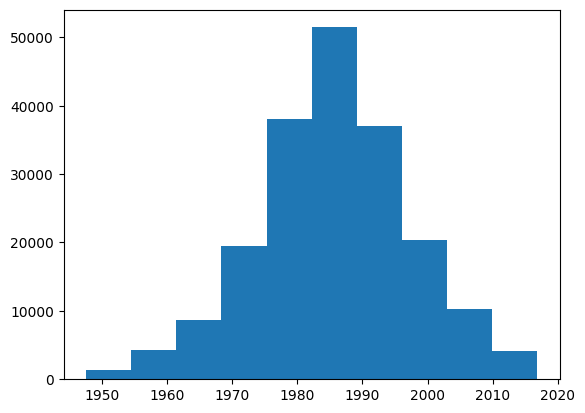

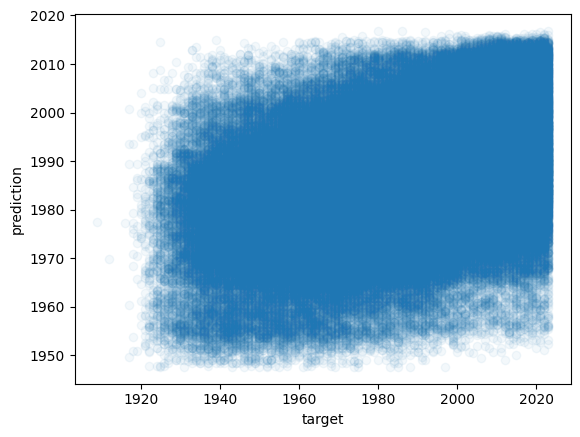

In [ ]:
#preds_demo = [pred * year_std + year_mean for pred in predictions ]
#targs_demo = [targ * year_std + year_mean for targ in targets]
preds_demo = [pred for pred in predictions ]
targs_demo = [targ for targ in targets]

abs_diffs = [abs(pred-targ) for pred,targ in zip(preds_demo,targs_demo)]

import matplotlib.pyplot as plt
plt.hist(preds_demo)
plt.show()

plt.scatter(targs_demo, preds_demo, alpha=0.05)
plt.xlabel("target")
plt.ylabel("prediction")
plt.show()

In [ ]:
print(np.mean(abs_diffs))
# compared to sqrt(490)=22, 18 is a considerable improvement (but would need )


17.702465735376837


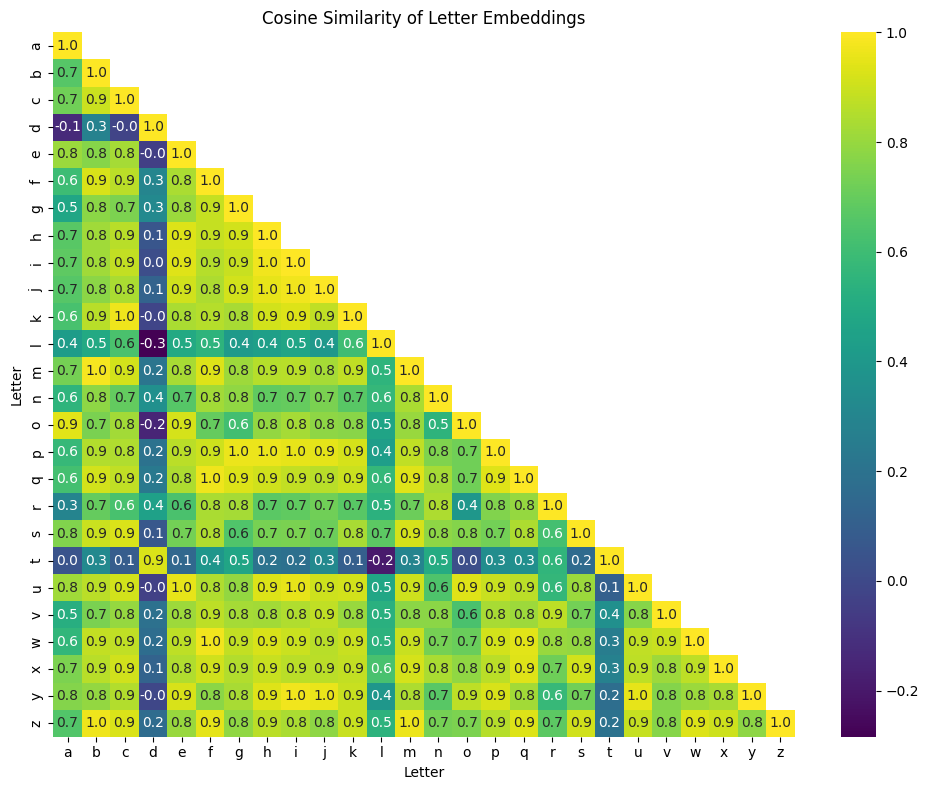

In [ ]:
import seaborn as sns

letters = list('abcdefghijklmnopqrstuvwxyz')
indexed_letters = [char_to_idx[letter] for letter in letters]

pretrained_bert.eval()
cosine_matrix = torch.full((len(letters), len(letters)), float('nan'))  # fill with NaN

with torch.no_grad():
  for i in range(len(letters)):
      for j in range(i + 1):  # only lower triangle including diagonal
          idx_i = torch.tensor([[indexed_letters[i]]]).to(device)
          idx_j = torch.tensor([[indexed_letters[j]]]).to(device)
          emb_i = pretrained_bert.to(device).get_embedding(idx_i)
          emb_j = pretrained_bert.to(device).get_embedding(idx_j)
          sim = torch.nn.functional.cosine_similarity(emb_i[0, 0], emb_j[0, 0], dim=0).item()
          #print(sim)
          cosine_matrix[i, j] = sim

pyplot.figure(figsize=(10, 8))
sns.heatmap(cosine_matrix.cpu().numpy(), xticklabels=letters, yticklabels=letters,
            annot=True, fmt=".1f", cmap="viridis"#, mask=np.isnan(cosine_matrix)
            )
pyplot.title("Cosine Similarity of Letter Embeddings")
pyplot.xlabel("Letter")
pyplot.ylabel("Letter")
pyplot.tight_layout()
pyplot.show()
